# Auto MPG

# NJIT

John Morrison  
Joseph Bennett

The goal of this project is to estimate the miles per gallon (mpg) of the different types of cars given a set of other attributes of the car, for example, the number of cylinders in the engine, the weight of the car, the model year, etc...

* The data set is maintained by Carniege Mellon and can be downloaded from [UCI Machine Learning](https://archive.ics.uci.edu/ml/datasets/auto+mpg).
* The methods for generating the models were found at [SciLearn](https://scikit-learn.org/stable/modules/linear_model.html).
* The rationale for using Ridge Regression was found from [NCSS](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Ridge_Regression.pdf).
* The definition of Lasso Regression was found on [Wikipedia](https://en.wikipedia.org/wiki/Lasso_(statistics)).

## Necessary Libraries

We want to predict a numerical value for the miles per gallon (mpg) therefore the models we use will be linear regression models:
1. Ordinary Least Squares model,
2. Ridge Regression model,
3. Lasso Regression model,
4. Support Vecrot Regression model.  

We will be using cross validation in order to minimize overfitting.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import svm
from sklearn.svm import SVR, LinearSVC, SVC
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Read data

In [2]:
data = pd.read_csv('auto-mpg.data', sep='\s+')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## Data Preprocessing

The data is not clean. Some of the values of horsepower are not known and marked with '?' to indicate this.

In [3]:
data.where(data['horsepower'] == '?').dropna()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
32,25.0,4.0,98.0,?,2046.0,19.0,71.0,1.0,ford pinto
126,21.0,6.0,200.0,?,2875.0,17.0,74.0,1.0,ford maverick
330,40.9,4.0,85.0,?,1835.0,17.3,80.0,2.0,renault lecar deluxe
336,23.6,4.0,140.0,?,2905.0,14.3,80.0,1.0,ford mustang cobra
354,34.5,4.0,100.0,?,2320.0,15.8,81.0,2.0,renault 18i
374,23.0,4.0,151.0,?,3035.0,20.5,82.0,1.0,amc concord dl


In [4]:
data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

We will drop this data because the horsepower variable is important in determining the mpg target variable. We will also need to convert the horsepower variable to a numeric type becuase, when it was loaded it was automatically converted to an 'object' type.

In [5]:
data = data[data['horsepower'] != '?']
data['horsepower'] = pd.to_numeric(data['horsepower'])

In [6]:
data.shape

(392, 9)

In [7]:
data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

Drop the car name, this is not used in the regression analysis.

In [8]:
data = data.drop(['car_name'], axis=1)

## Setup the target (cross_y) and Independent (cross_X) variables

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['mpg'], axis=1), pd.DataFrame(data, columns=['mpg']), 
    test_size=0.10, random_state=42)
#cross_X = data.drop(['mpg'], axis=1)
#cross_y = pd.DataFrame(data, columns=['mpg'])

Data Normalization

In [18]:
min_train = X_train.min(axis=0)
max_train = X_train.max(axis=0)

range_train = (X_train - min_train).max(axis=0)
range_train_new = max_train-min_train

X_train_scaled = (X_train - min_train)/range_train
X_test_scaled = (X_test - min_train)/range_train

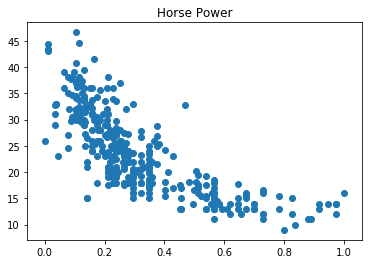

In [32]:
plt.scatter(X_train_scaled['horsepower'],y_train)
plt.title('Horse Power')
plt.show()

## Independent 

In [19]:
X_train_scaled.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
73,1.0,0.615584,0.456522,0.704565,0.357143,0.166667,0.0
147,0.2,0.051948,0.157609,0.140346,0.446429,0.333333,0.5
375,0.2,0.090909,0.152174,0.104054,0.434524,1.000000,0.5
143,0.2,0.070130,0.173913,0.194783,0.386905,0.333333,0.5
159,1.0,0.729870,0.554348,0.863056,0.327381,0.416667,0.0


## Target

In [20]:
y_train.head()

,mpg
73,13.0
147,24.0
375,36.0
143,26.0
159,14.0


## Building the Models

#### Selected Models
1. Ordinary Least Squares
2. Ridge Regression
3. Lasso
4. Support Vector Regression

### Ordinary Least Squares

According to [Skilearn](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares), Ordinary Least Squares will attempt to fit a linear model that will minimize the residual sum of squares between the observed responses in the dataset, and the responses predicted by the linear approximation

Accuracy scores for a k=5 Cross validation for an Ordinary Least Squares Linear Model.

In [66]:
model = LinearRegression()
parameters = {'fit_intercept':[True, False],
              'normalize':[True, False],
              'copy_X':[True,False]}
ols = GridSearchCV(model, parameters, cv=5, scoring="r2")
ols.fit(X_train_scaled, y_train)
ols_pred_train = ols.predict(X_train_scaled)
ols_pred_test = ols.predict(X_test_scaled)
print ("r2 / variance: {0:.4f}".format(ols.best_score_))
print ("Residual sum of squares training set: {0:.4f}".format(np.mean((pred_train-y_train)**2)[0]))
print ("Residual sum of squares testing set: {0:.4f}".format(np.mean((pred_test-y_test)**2)[0]))

r2 / variance: 0.8015
Residual sum of squares training set: 11.1156
Residual sum of squares testing set: 8.6272


### Residual Plot

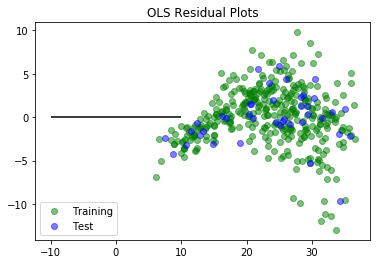

In [67]:
train = plt.scatter(ols_pred_train,(ols_pred_train-y_train),c='g',alpha=0.5)
test = plt.scatter(ols_pred_test,(ols_pred_test-y_test),c='b',alpha=0.5)
plt.hlines(y=0, xmin=-10,xmax=10)
plt.legend((train,test),('Training','Test'),loc='lower left')
plt.title('OLS Residual Plots')
plt.show()

### Ridge Regression

Ridge Regression addresses issues with multicollinearity ([NCSS](https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Ridge_Regression.pdf)). Multicollinearity is a feature of a dataset where one independent variable can be predicted by other independent variables within the dataset.

Accuracy scores for a k=5 Cross validation for a Ridge Regression Linear Model

In [69]:
model = Ridge()
parameters = {'alpha':[.1,.2,.3]}
ridge = GridSearchCV(model, parameters, cv=5, scoring="r2")
ridge.fit(X_train_scaled, y_train)
ridge_pred_train = ridge.predict(X_train_scaled)
ridge_pred_test = ridge.predict(X_test_scaled)
print ("r2 / variance: {0:.4f}".format(ridge.best_score_))
print ("Residual sum of squares training set: {0:.4f}".format(np.mean((ridge_pred_train-y_train)**2)[0]))
print ("Residual sum of squares testing set: {0:.4f}".format(np.mean((ridge_pred_test-y_test)**2)[0]))

r2 / variance: 0.8018
Residual sum of squares training set: 11.1243
Residual sum of squares testing set: 8.7493


The accuracy scores for ridge regression are not very different from the ordinary least squares scores. This means that multicollinearity is not a real issue with this dataset.

### Lasso Regression

Lasso Regression is a regression analysis method that performs both variable selection and regularization in order to  enhance the prediction accuracy and the interpretibility of the statistical model it produces [from Wikipedia](https://en.wikipedia.org/wiki/Lasso_(statistics)).

Accuracy scores for a k=5 Cross validation for a Lasso Regression Linear Model

In [27]:
model = Lasso()
parameters = {'alpha':[.1,.2,.3]}
lasso = GridSearchCV(model, parameters, cv=5, scoring="r2")
lasso.fit(X_train_scaled, y_train)
print ("r2 / variance: {0:.4f}".format(lasso.best_score_))
##(lasso.predict(X_test_scaled)-y_test)**2
#print ("Residual sum of squares: {0:.4f}".format(np.mean((lasso.predict(X_test)-y_test)**2)[0]))
#lasso_scores = cross_val_score(lasso, cross_X, cross_y, scoring='neg_mean_squared_error', cv=5)
#np.mean(lasso_scores)

r2 / variance: 0.8009


### Support Vector Regression

Accoriding to [Scikit-learn](https://scikit-learn.org/stable/modules/svm.html#svm-regression), Support Vector Classification can be extended to regression as well.  

In [30]:
svr_rbf = SVR(gamma='scale')
svr_rbf_scores = cross_val_score(svr_rbf, cross_X, cross_y.values.ravel(), scoring='neg_mean_squared_error', cv=5)
np.mean(svr_rbf_scores)

TypeError: a float is required

In [43]:
clf = svm.LinearSVC()
clf.fit(X_train_scaled,y_train['mpg'])
clf.predict(X_test_scaled)

ValueError: Unknown label type: 'continuous'